In [45]:
#!pip install requirements.txt

In [47]:
import os, io, re, csv, json, base64, statistics
from pathlib import Path
from typing import List, Dict, Any
import requests
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from pdf2image import convert_from_path
from pypdf import PdfReader, PdfWriter, Transformation
from pypdf.generic import NameObject, NumberObject
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
Root = Path().resolve().parent
print("Root DIR:", Root)

Root DIR: /Users/mariostsoukis/Documents/NYU/OCR_Work/1951


## Part 1: Pre-Processing

Correct the orientation.

In [19]:
# Paths
input_pdf  = Root / "PDF" / "USIMC1951.pdf"
output_pdf = Root / "PDF" / "USIMC1951_Oriented.pdf"

reader = PdfReader(str(input_pdf))
writer = PdfWriter()

In [20]:
for page in reader.pages:
    raw_w = float(page.mediabox.width)
    raw_h = float(page.mediabox.height)

    current_rot = page.get("/Rotate", 0) % 360

    # Figure out “effective” width/height after rotation
    if current_rot in (90, 270):
        eff_w, eff_h = raw_h, raw_w
    else:
        eff_w, eff_h = raw_w, raw_h

    #If portrait,rotate by 90°
    if eff_w < eff_h:
        new_rot = (current_rot + 90) % 360
        page[NameObject("/Rotate")] = NumberObject(new_rot)

    writer.add_page(page)

# Write out
with open(output_pdf, "wb") as out_f:
    writer.write(out_f)

print(f"Oriented PDF saved to {output_pdf}")

Oriented PDF saved to /Users/mariostsoukis/Documents/NYU/OCR_Work/1951/PDF/USIMC1951_Oriented.pdf


Now I trim a bit. This will make later pre-processing steps both easier and (a touch) faster. 

In [21]:
# New input and output paths
input_pdf  = Root / "PDF" / "USIMC1951_Oriented.pdf"
output_pdf = input_pdf.parent / "USIMC1951_oriented_cropped.pdf"

reader = PdfReader(str(input_pdf))
writer = PdfWriter()


In [22]:
for page in reader.pages:
    # full page dims
    llx, lly = page.mediabox.lower_left
    urx, ury = page.mediabox.upper_right
    width  = urx - llx
    height = ury - lly

    # how much to remove; ignore bottom/left. For some reason this works. 
    crop_bottom = height * 0.20   
    crop_left   = width  * 0.1     

    # new lower-left corner
    new_llx = llx + crop_left
    new_lly = lly + crop_bottom

    # apply to both mediaBox and cropBox
    page.mediabox.lower_left = (new_llx, new_lly)
    page.cropbox.lower_left  = (new_llx, new_lly)
    writer.add_page(page)

# save
with open(str(output_pdf), "wb") as out_f:
    writer.write(out_f)
print(f"Cropped PDF saved to: {output_pdf}")

Cropped PDF saved to: /Users/mariostsoukis/Documents/NYU/OCR_Work/1951/PDF/USIMC1951_oriented_cropped.pdf


Create temporary files for rotation.

In [23]:
CROPPED_PDF = Root / "PDF" / "USIMC1951_oriented_cropped.pdf"
OUTPUT_DIR  = Root / "PNG_Temp"

pages = convert_from_path(str(CROPPED_PDF), dpi=200) # no need for high quality

for idx, page in enumerate(pages, start=1):
    out_path = OUTPUT_DIR / f"page_{idx:03d}.png"
    page.save(out_path, "PNG");

folder = Root / "PNG_Temp"

I deskew images- basically I project horizontal beams onto pixels and find which small rotation maximises variance. This simulates trying to find edges. Images first binarized. 

In [24]:
def find_score(arr, angle):
    h, w = arr.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    rot = cv2.warpAffine(arr, M, (w, h),
                        flags=cv2.INTER_NEAREST,
                        borderMode=cv2.BORDER_REPLICATE)
    hist = np.sum(rot, axis=1)
    return np.sum(np.diff(hist)**2)

#If I wanted more generelizable function, I would just put these in when calling- but it's fine. 
def deskew_images(folder: Path, delta=0.01, limit=1.0):
    angles = np.arange(-limit, limit + delta, delta)
    log_lines = []

    for img_path in sorted(folder.iterdir()):

        # load gray & build mask
        gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
        mask = bw.astype(np.float32) / 255.0

        # find best angle
        scores = [find_score(mask, a) for a in angles]
        best = angles[int(np.argmax(scores))]
        log_lines.append(f"{img_path.name}\t{best:.2f}")

        # rotate image
        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), best, 1.0)
        rotated = cv2.warpAffine(
            img, M, (w, h),
            flags=cv2.INTER_LANCZOS4,
            borderMode=cv2.BORDER_REPLICATE
        )

        cv2.imwrite(str(img_path), rotated)

    # write log
    log_file = folder / "rotation.txt"
    log_file.write_text("\n".join(log_lines))
    print(f"Rotated {len(log_lines)} images. Log → {log_file}")
    deskew_images(folder)

In [25]:
pdf_in      = Root / "PDF" / "USIMC1951_oriented_cropped.pdf"
rot_txt     = Root / "PNG_Temp" / "rotation.txt"
pdf_out     = pdf_in.with_name(pdf_in.stem + "_rotated.pdf")

reader = PdfReader(pdf_in)
writer = PdfWriter()

In [31]:
# Read the angles 
angles = []
with rot_txt.open() as f:
    for line in f:
        _, ang = line.strip().split()
        angles.append(float(ang))



# Apply a pure-rotation about the page center to each page
for page, angle in zip(reader.pages, angles):
        writer.add_page(page)
        continue

    # compute center of the media box
mb = page.mediabox
x0 = (float(mb.right)  - float(mb.left))  / 2
y0 = (float(mb.top)    - float(mb.bottom)) / 2

t = (
    Transformation()
    .translate(tx=-x0, ty=-y0)
    .rotate(angle)
    .translate(tx= x0, ty= y0)
)

# apply
page.add_transformation(t)
writer.add_page(page)

with open(pdf_out, "wb") as out_f:
    writer.write(out_f)

print(f"Saved rotated PDF to:\n   {pdf_out}")

Saved rotated PDF to:
   /Users/mariostsoukis/Documents/NYU/OCR_Work/1951/PDF/USIMC1951_oriented_cropped_rotated.pdf


Now let's see our images. (Note- I do this with not-deskewed images)

In [32]:
CROPPED_PDF = Root / "PDF" / "USIMC1951_oriented_cropped.pdf"
OUTPUT_DIR  = Root / "PNG"

# convert each page to a PIL.Image
pages = convert_from_path(str(CROPPED_PDF), dpi=700)

# save with unique name
for idx, page in enumerate(pages, start=1):
    out_path = OUTPUT_DIR / f"page_{idx:03d}.png"
    page.save(out_path, "PNG")

More Cleaning: Example

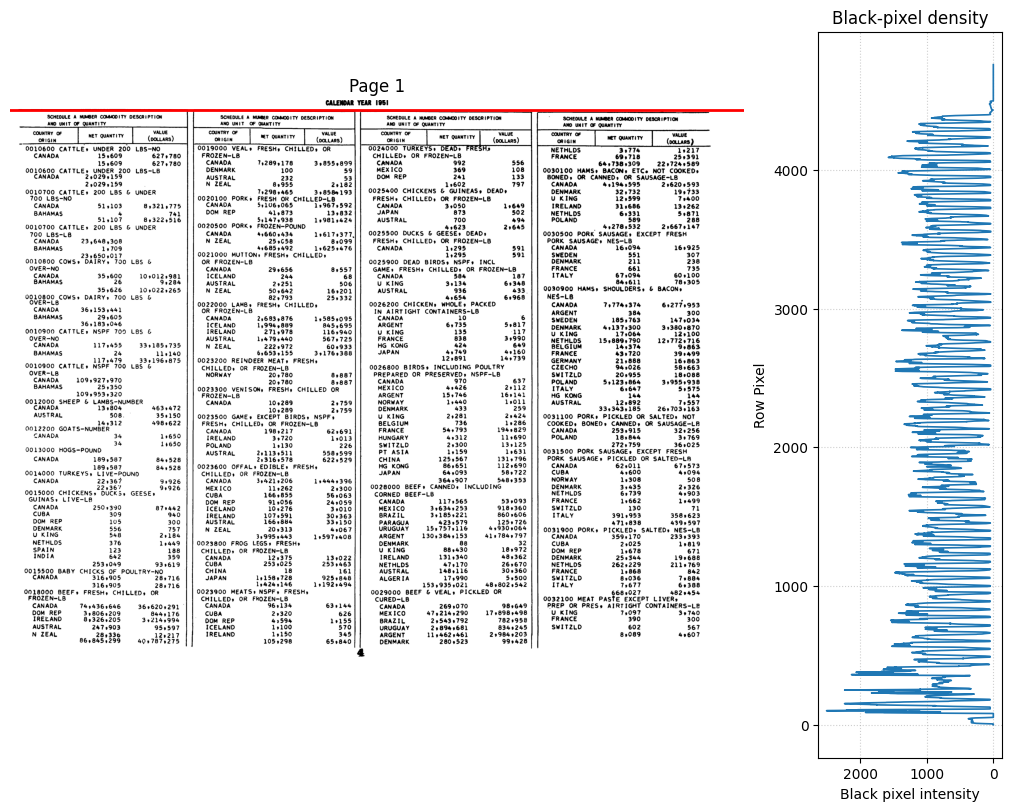

In [33]:
Image = Root / "PNG" / "page_001.png"

# Biniarize the image and find the horizontal density profile
gray = cv2.imread(str(Image), cv2.IMREAD_GRAYSCALE)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
black_density_row = (bw == 0).sum(axis=1)   

#  Find the last zero-density row in the top half of the image
height = bw.shape[0]
top_half_limit = height // 2
zero_rows_in_top = np.where(black_density_row[:top_half_limit] == 0)[0]
if zero_rows_in_top.size > 0:
    last_zero_row = zero_rows_in_top[-1]
else:
    last_zero_row = None  # no completely empty row in top half

#  Plot: original page + horizontal density profile to the right
fig, (ax_img, ax_density) = plt.subplots(
    ncols=2,
    figsize=(10, 8),
    gridspec_kw={"width_ratios": [4, 1]},  
    constrained_layout=True
)

#  left panel: raw scan with red line 
ax_img.imshow(gray, cmap="gray")
ax_img.set_title("Page 1")
ax_img.axis("off")
# draw a red horizontal line at the last zero-density row
if last_zero_row is not None:
    ax_img.axhline(y=last_zero_row, color="red", linewidth=2)

# -- right panel: horizontal density profile --------------------------------
ax_density.plot(black_density_row, np.arange(len(black_density_row)), linewidth=1.2)
ax_density.invert_xaxis()                  
ax_density.set_title("Black-pixel density")
ax_density.set_xlabel("Black pixel intensity")
ax_density.set_ylabel("Row Pixel")
ax_density.grid(ls=":", alpha=0.6)

plt.show()


So we get: 

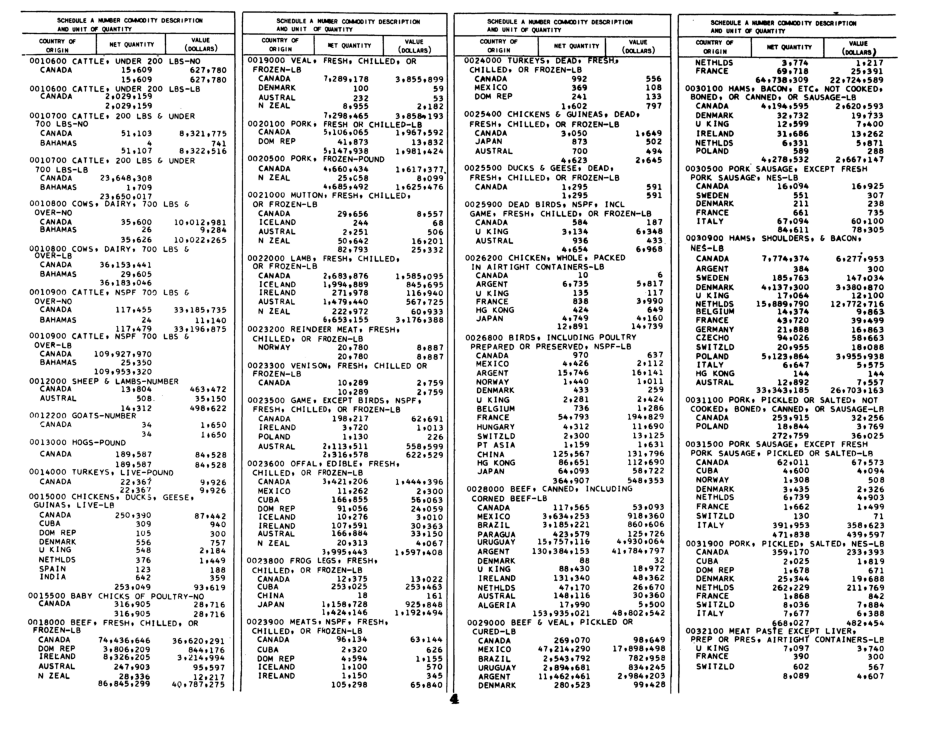

In [37]:
if last_zero_row is not None:
    # 5 pixels above the detected line- buffer
    crop_start = max(0, last_zero_row - 10)
    # keep all rows from crop_start downwards
    cropped_image = gray[crop_start:, :]
else:
    # fallback: leave the image intact
    cropped_image = gray.copy()

plt.figure(figsize=(12, 12))
plt.imshow(cropped_image, cmap="gray")
plt.axis("off")
plt.show()

We can do better. We can also try to cut the bottom whitespace- trying the same thing we did above to crop image. Additionally, we can try to identify blocks. We run same process as above, but with vertical beams, and additionally diulte the image before doing so. The reason is to catch the columns, but also catch small skews in columns- so when e.g column line runs slightly diagonal. 

In [35]:
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
black_density_row = (bw == 0).sum(axis=1)
top_half = bw.shape[0] // 2
zero_rows_top = np.where(black_density_row[:top_half] == 0)[0]
if zero_rows_top.size == 0:
    raise ValueError("No completely empty row found in the top half")
last_zero_row = zero_rows_top[-1]
crop_start = max(last_zero_row - 5, 0)
cropped = gray[crop_start:, :]

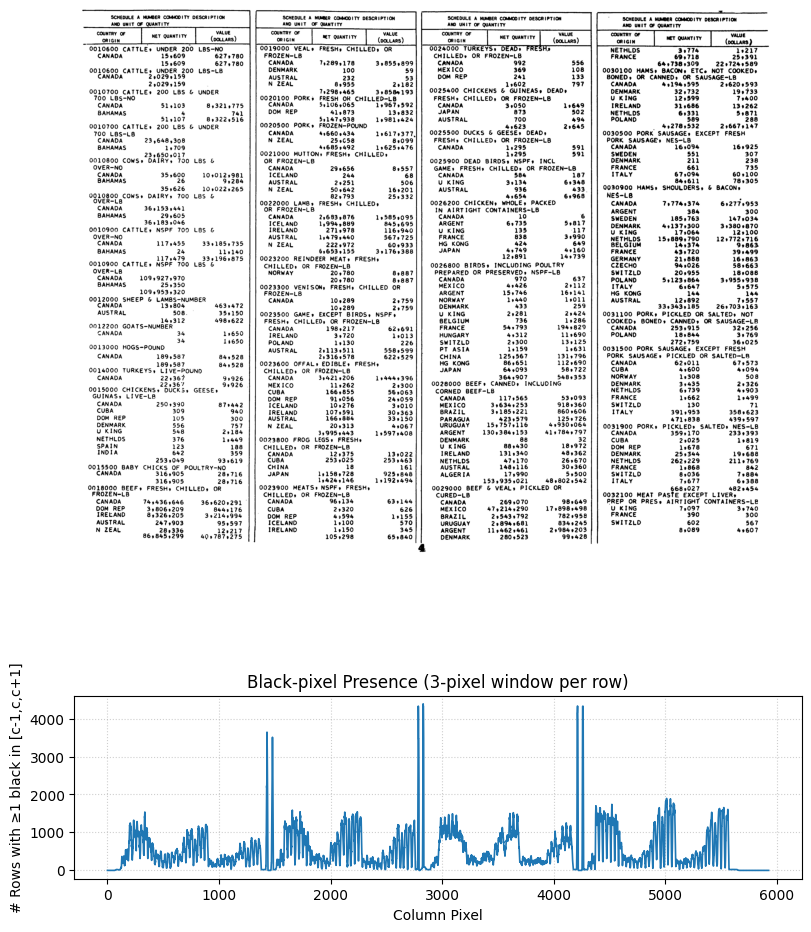

In [36]:
mask = (cropped == 0).astype(np.uint8)   # 1 where ink, 0 elsewhere

#  For each row, I dilate horizontally by 1 pixel on each side,
#  so any stretch of 1–3 adjacent black pixels in that row
#  becomes a single TRUE pixel in presence map:
left_shift  = np.zeros_like(mask)
right_shift = np.zeros_like(mask)
left_shift[:, 1:]  = mask[:, :-1]
right_shift[:, :-1] = mask[:, 1:]

presence = ((mask + left_shift + right_shift) > 0).astype(np.uint8)

# density profile
black_density_sliding3 = presence.sum(axis=0)

# Plot
fig, (ax_img, ax_den) = plt.subplots(
    nrows=2, figsize=(8, 10),
    gridspec_kw={"height_ratios": [4, 1]},
    constrained_layout=True
)

ax_img.imshow(cropped, cmap="gray", origin="upper")
ax_img.axis("off")

ax_den.plot(black_density_sliding3, linewidth=1.2)
ax_den.set_title("Black-pixel Presence (3-pixel window per row)")
ax_den.set_xlabel("Column Pixel")
ax_den.set_ylabel("# Rows with ≥1 black in [c-1,c,c+1]")
ax_den.grid(ls=":", alpha=0.6)

plt.show()

We can clearly identify the columns!!

I basically do this, but to all images: 

I include all intermediate steps- so I can play around with parameters and change images. 

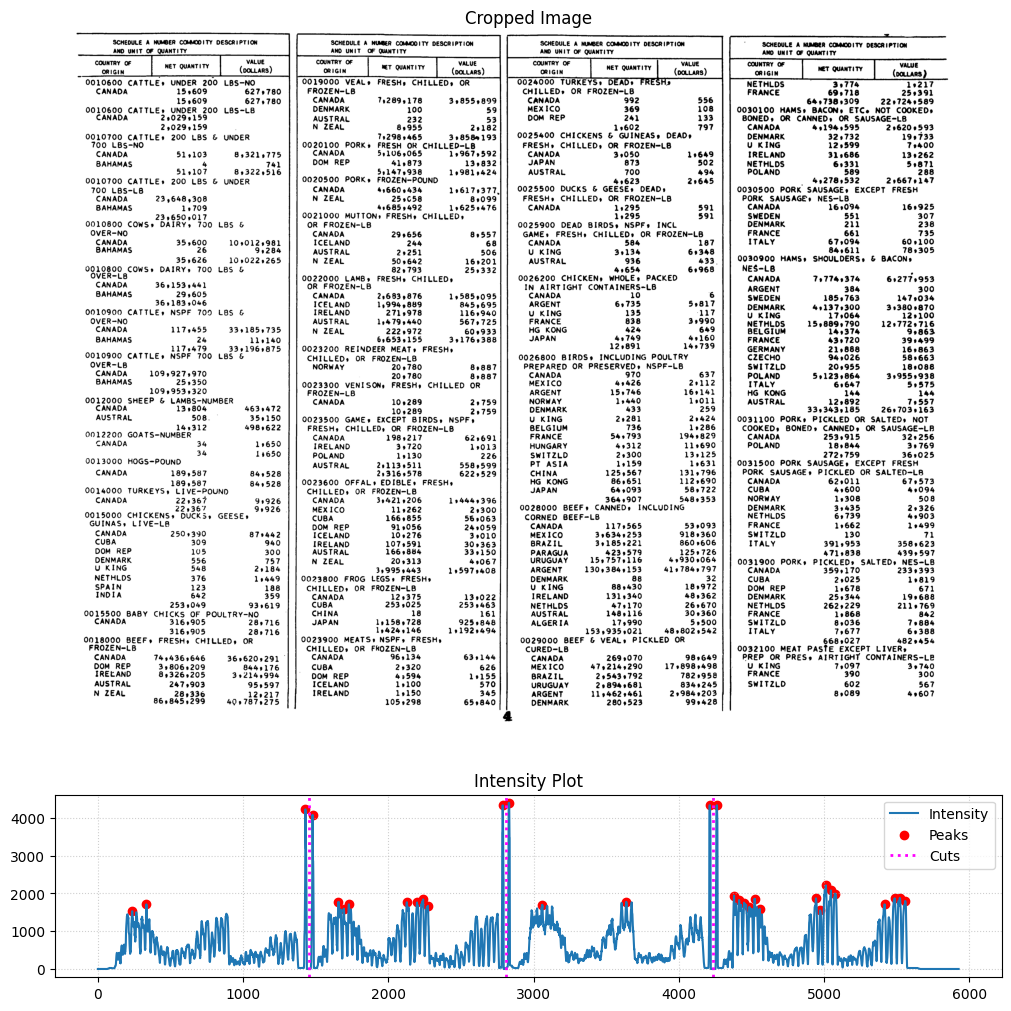

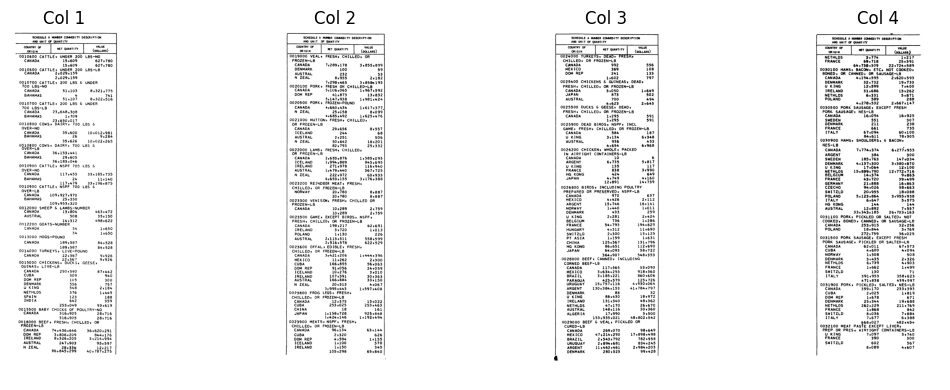

In [40]:
# ───────────────────────── CONFIG ───────────────────────────
Image           = Root / "PNG" / "page_001.png"  # play around and see end result from whatever photo I want
output_dir      = Root / "Images"                 

PEAK_HEIGHT     = 1800
PEAK_PROMINENCE = 1000
MAX_PEAK_GAP    = 100    # only pair peaks within 75 px
NCOLS           = 4      # column count
MIN_CUT_SEP     = 100     #minimum separation between cut points (pixels)

def sliding_window_presence(bw: np.ndarray) -> np.ndarray:
    """Return per‑column presence of foreground, diluted by 1 pixel."""
    mask        = (bw == 0).astype(np.uint8)
    left_shift  = np.zeros_like(mask);  left_shift[:, 1:]   = mask[:, :-1]
    right_shift = np.zeros_like(mask);  right_shift[:, :-1] = mask[:, 1:]
    presence    = mask | left_shift | right_shift
    return presence.sum(axis=0)

gray = cv2.imread(str(Image), cv2.IMREAD_GRAYSCALE)
_, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# crop
h, w = bw.shape
half = h // 2
rowsum = (bw == 0).sum(axis=1)
zeros  = np.where(rowsum[:half] == 0)[0]
crop_start = max(zeros[-1] - 10, 0) if zeros.size else 0
gray_crop = gray[crop_start:]
bw_crop   = bw[crop_start:]

# per‑column density of black pixels (diluted)
density = sliding_window_presence(bw_crop)

#  Detect peaks
peaks, _ = find_peaks(
    density,
    height=PEAK_HEIGHT,
    prominence=PEAK_PROMINENCE,
)
if len(peaks) < 2:
    raise RuntimeError(f" Tenim un problema")

#  Pair  neighbouring peaks that are close
#  For each pair, use the midpoint to cut. 
pairs = []
for L, R in zip(peaks[:-1], peaks[1:]):
    if (R - L) <= MAX_PEAK_GAP:
        midpoint = (L + R) // 2
        score    = density[L] + density[R]
        pairs.append((midpoint, score))

if not pairs:
    raise RuntimeError(f"Tenim un problema")

#  Select the (NCOLS‑1) strongest candidate cuts given they are at least
#  MIN_CUT_SEP pixels apart. Also- they cannot be too close. 

pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
selected: list[int] = []
for midpoint, _score in pairs_sorted:
    if all(abs(midpoint - prev) >= MIN_CUT_SEP for prev in selected):
        selected.append(midpoint)
    if len(selected) == NCOLS - 1:
        break

if len(selected) < NCOLS - 1:
    raise RuntimeError(
        f"Tenim un problema"
    )
cut_points = sorted(selected)

# ───────────────────── VISUALISE DENSITY & CUTS ──────────────────────
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(10, 10),
    gridspec_kw={"height_ratios": [4, 1]},
    constrained_layout=True,
)
ax1.imshow(gray_crop, cmap="gray")
ax1.axis("off")
ax1.set_title("Cropped Image")

ax2.plot(density, label="Intensity")
ax2.scatter(peaks, density[peaks], c="red", label="Peaks")
for x in cut_points:
    ax2.axvline(x, color="magenta", ls=":", lw=2, label="Cuts" if x == cut_points[0] else "")
ax2.set_title("Intensity Plot")
ax2.legend(); ax2.grid(ls=":", alpha=0.6)
plt.show()

# Visualise
bounds   = [0] + cut_points + [w]
fig2, axs = plt.subplots(1, NCOLS, figsize=(NCOLS * 3, 4))
for i in range(NCOLS):
    x1, x2 = bounds[i], bounds[i + 1]
    blk = gray_crop[:, x1:x2]
    axs[i].imshow(blk, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Col {i + 1}")
plt.tight_layout()
plt.show()

suffixes = ["a", "b", "c", "d"]
for i, (x1, x2) in enumerate(zip(bounds, bounds[1:]), start=1):
    block = gray_crop[:, x1:x2]
    if block.size == 0:
        print(f"⚠️ Column {i} empty—skipping.")
        continue
    up = cv2.resize(
        block,
        (block.shape[1] * 2, block.shape[0] * 2),
        interpolation=cv2.INTER_CUBIC,
    )
    fn  = f"{Image.stem}{suffixes[i - 1]}{Image.suffix}"
    out = output_dir / fn

Molt bé. Now overall:

In [41]:
input_dir       = Root / "PNG"                
output_dir      = input_dir.parent / "Images"

PEAK_HEIGHT     = 1800   
PEAK_PROMINENCE = 1000  
MAX_PEAK_GAP    = 110    
NCOLS           = 4    
UPSCALE_FACTOR  = 1      
BUFFER_PIXELS   = 10    
MIN_CUT_SEP     = 100    


def sliding_window_presence(bw: np.ndarray) -> np.ndarray:
    mask        = (bw == 0).astype(np.uint8)
    left_shift  = np.zeros_like(mask);  left_shift[:, 1:]   = mask[:, :-1]
    right_shift = np.zeros_like(mask);  right_shift[:, :-1] = mask[:, 1:]
    presence    = mask | left_shift | right_shift
    return presence.sum(axis=0)


suffixes = [chr(ord('a') + i) for i in range(NCOLS)]

for img_path in sorted(input_dir.glob("page_*.png")):
    gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    # Binarise
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Crops
    h, w = bw.shape
    half = h // 2
    rowsum = (bw == 0).sum(axis=1)
    blank_rows = np.where(rowsum[:half] == 0)[0]
    crop_start = max(blank_rows[-1] - BUFFER_PIXELS, 0) if blank_rows.size else 0
    gray_crop = gray[crop_start:, :]
    bw_crop   = bw[crop_start:, :]
    h2 = bw_crop.shape[0]
    half2 = h2 // 2
    rowsum2 = (bw_crop == 0).sum(axis=1)
    blank_bottom = np.where(rowsum2[half2:] == 0)[0]
    end_row = min(half2 + blank_bottom[0] + BUFFER_PIXELS, h2) if blank_bottom.size else h2
    gray_crop = gray_crop[:end_row, :]
    bw_crop   = bw_crop[:end_row, :]

    # Density signal 
    density = sliding_window_presence(bw_crop)

    # Peaks
    peaks, _ = find_peaks(
        density,
        height=PEAK_HEIGHT,
        prominence=PEAK_PROMINENCE,
    )

    pairs = []
    for L, R in zip(peaks[:-1], peaks[1:]):
        if (R - L) <= MAX_PEAK_GAP:
            midpoint = (L + R) // 2
            score    = density[L] + density[R]
            pairs.append((midpoint, score))


    #  Select the strongest 
    pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
    selected: list[int] = []
    for midpoint, _score in pairs_sorted:
        if all(abs(midpoint - prev) >= MIN_CUT_SEP for prev in selected):
            selected.append(midpoint)
        if len(selected) == NCOLS - 1:
            break

    cut_points = sorted(selected)
    bounds     = [0] + cut_points + [bw_crop.shape[1]]

    #  Slice, optionally upscale, and save each column
    for i, (x1, x2) in enumerate(zip(bounds, bounds[1:])):
        block = gray_crop[:, x1:x2]
        if block.size == 0:
            print(f"  Col {i + 1} empty, skipping.")
            continue

        up = cv2.resize(
            block,
            (block.shape[1] * UPSCALE_FACTOR, block.shape[0] * UPSCALE_FACTOR),
            interpolation=cv2.INTER_CUBIC,
        )

        out_name = f"{img_path.stem}{suffixes[i]}{img_path.suffix}"
        out_path = output_dir / out_name
        cv2.imwrite(str(out_path), up)
        print(f"    Saved {out_name}")


    Saved page_001a.png
    Saved page_001b.png
    Saved page_001c.png
    Saved page_001d.png
    Saved page_002a.png
    Saved page_002b.png
    Saved page_002c.png
    Saved page_002d.png
    Saved page_003a.png
    Saved page_003b.png
    Saved page_003c.png
    Saved page_003d.png
    Saved page_004a.png
    Saved page_004b.png
    Saved page_004c.png
    Saved page_004d.png
    Saved page_005a.png
    Saved page_005b.png
    Saved page_005c.png
    Saved page_005d.png
    Saved page_006a.png
    Saved page_006b.png
    Saved page_006c.png
    Saved page_006d.png
    Saved page_007a.png
    Saved page_007b.png
    Saved page_007c.png
    Saved page_007d.png
    Saved page_008a.png
    Saved page_008b.png
    Saved page_008c.png
    Saved page_008d.png
    Saved page_009a.png
    Saved page_009b.png
    Saved page_009c.png
    Saved page_009d.png
    Saved page_010a.png
    Saved page_010b.png
    Saved page_010c.png
    Saved page_010d.png
    Saved page_011a.png
    Saved page_0

## Part 2: OCR and Inference

Surya-OCR
For some reason, GPU and CPU version give different answers. CPU does better- but is SLOW. 

In [ ]:
!TORCH_DEVICE=cpu \
  PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 \
  DETECTOR_BLANK_THRESHOLD=0.4 \
  DETECTOR_TEXT_THRESHOLD=0.7 \
  surya_ocr../Images \
    --output_dir ../Output \
    --images \
    --disable_math

Useful below to help tune settings:

In [ ]:
!TORCH_DEVICE=cpu \
  PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 \
  DETECTOR_BLANK_THRESHOLD=0.4 \
  DETECTOR_TEXT_THRESHOLD=0.7 \
  surya_detect ../Images \
    --output_dir ../Output \
    --images \
    --debug

View example:

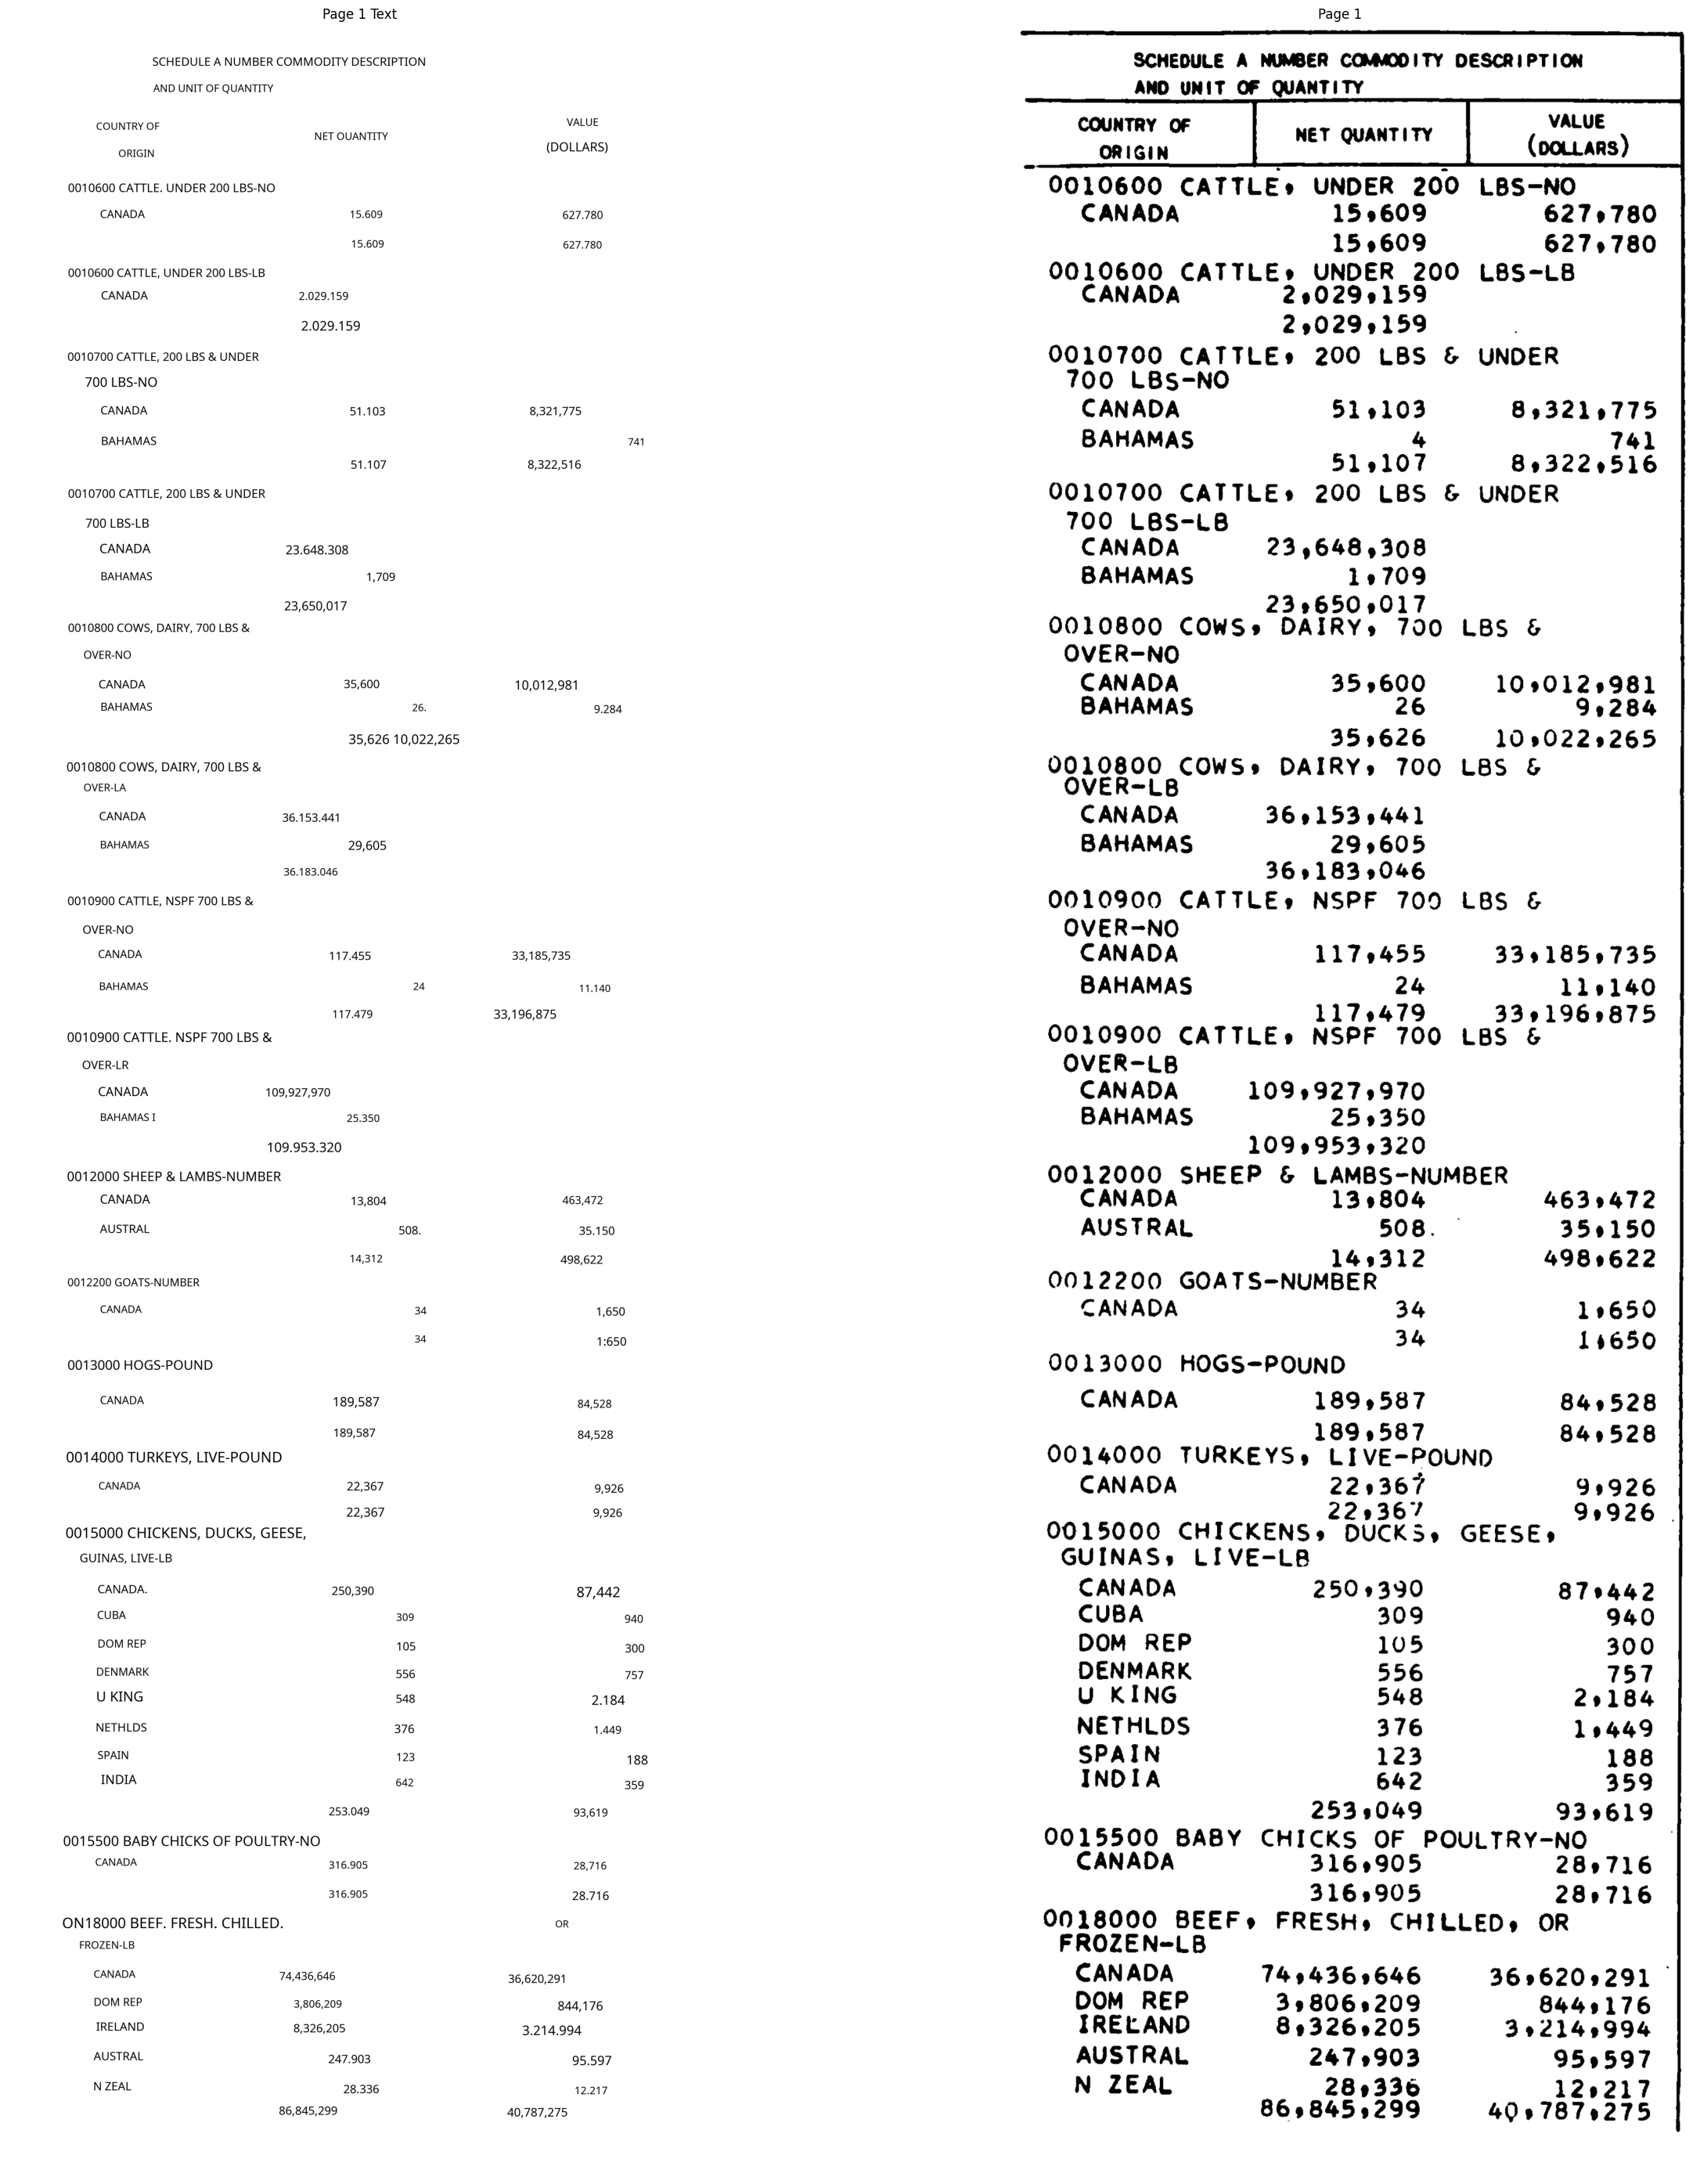

In [44]:

# paths. This is example- run code to populate results and choose image of your liking.
img_path1 =  Root / 'Output' / 'Images' / 'page_001a_236_text.png'
img_path2 =  Root / 'Images' / 'page_001a.png'

# read images
img1 = mpimg.imread(img_path1)
img2 = mpimg.imread(img_path2)

# plot
fig, axes = plt.subplots(1, 2, figsize=(28,28))
axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Page 1 Text')

axes[1].imshow(img2, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Page 1')

plt.tight_layout()
plt.show()

In [51]:

JSON_FILE     = Root / "Images" / "results.json"

OUT_DIR       = JSON_FILE.parent
right_margin  = 0.15   # percentage of page width regarded as the "value" zone
min_left_digits = 3    # number of digits to be eligible to be a product code candidate


#  Helper regexes / functions
RX_CODE = re.compile(r"^\d{7}$")
RX_NUM  = re.compile(r"^[\d,.:•]+(?:\.\d+)?\.?$")
TAG_RE  = re.compile(r"<[^>]+>")

def strip_html(text: str) -> str:
    return TAG_RE.sub("", text).strip()

def digits_only(tok: str) -> str:
    return re.sub(r"[^\d]", "", tok)

def is_numeric(tok: str) -> bool:
    """Heuristic: looks like a number *and* has at least one digit after stripping."""
    return bool(RX_NUM.match(tok)) and digits_only(tok) != ""

def to_int(tok: str):
    d = digits_only(tok)
    return int(d) if d else None

#  Parse OCR page-dict
def parse_page(pg_dict: Dict[str, Any]) -> List[Dict[str, Any]]:

    # explode each OCR line into word-level tokens
    toks: List[Dict[str, Any]] = []
    for tl in pg_dict.get("text_lines", []):
        cleaned = strip_html(tl["text"])
        if not cleaned:
            continue
        for part in cleaned.split():
            toks.append({
                "txt": part,
                "x0" : tl["bbox"][0],
                "y0" : tl["bbox"][1],
                "x1" : tl["bbox"][2],
                "y1" : tl["bbox"][3],
            })

    if not toks:
        return []

    # page width for margin tests
    page_width            = max(t["x1"] for t in toks)
    right_edge_threshold  = page_width * (1 - right_margin)
    left_edge_threshold   = page_width / 3

    #  row segmentation based on vertical proximity
    toks.sort(key=lambda t: t["y0"])
    h_med = statistics.median(t["y1"] - t["y0"] for t in toks)
    tol   = h_med * 0.45

    rows, buf, last_y = [], [], None
    for t in toks:
        if last_y is None or abs(t["y0"] - last_y) <= tol:
            buf.append(t)
        else:
            rows.append(buf)
            buf = [t]
        last_y = t["y0"]
    if buf:
        rows.append(buf)

    # iterate over rows and build output records
    ctx   = {"code": None, "desc": "", "unit": None}
    recs: List[Dict[str, Any]] = []

    for r in rows:
        r.sort(key=lambda t: t["x0"])
        tokens = [tok["txt"] for tok in r]
        if not tokens:
            continue

        first_txt = tokens[0]
        first_box = r[0]

        # digits in the first token
        digit_count = sum(ch.isdigit() for ch in first_txt)

        #header row – either exactly 7 digits, or ≥ N digits & in the left third
        is_left_third_code = (
            digit_count >= min_left_digits
            and first_box["x0"] <= left_edge_threshold
            and first_box["x1"] <= left_edge_threshold
        )
        if RX_CODE.match(first_txt) or is_left_third_code:
            ctx["code"] = first_txt
            ctx["desc"] = " ".join(tokens[1:]).strip()
            ctx["unit"] = ctx["desc"].split("-")[-1] if "-" in ctx["desc"] else None
            continue

        # header continuation – no numeric tokens in the line
        #!!!! NEED TO CHANGE THIS- DOES NOT COVER ALL CASES!!!!
        if ctx["code"] and not any(is_numeric(t) for t in tokens):
            ctx["desc"] += " " + " ".join(tokens)
            if "-" in ctx["desc"]:
                ctx["unit"] = ctx["desc"].split("-")[-1]
            continue

        #data / subtotal rows
        num_indices = [i for i, tok in enumerate(tokens) if is_numeric(tok)]
        if not num_indices:
            continue

        def tok_box(idx: int) -> Dict[str, Any]:
            return r[idx]

        quantity = value = None

        if len(num_indices) == 1:
            idx   = num_indices[0]
            n_int = to_int(tokens[idx])
            box   = tok_box(idx)
            if box["x0"] >= right_edge_threshold or box["x1"] >= right_edge_threshold:
                value = n_int
            else:
                quantity = n_int
        else:
            quantity = to_int(tokens[num_indices[0]])
            value    = to_int(tokens[num_indices[-1]])

        country_tokens = [tok for tok in tokens if not is_numeric(tok)]
        country = " ".join(country_tokens) if country_tokens else "TOTAL"

        recs.append({
            "product_code"       : ctx["code"] or "",
            "product_description": ctx["desc"] if ctx["code"] else "",
            "unit"               : ctx["unit"] if ctx["code"] else "",
            "country"            : country,
            "quantity"           : quantity,
            "value"              : value,
        })

    return recs



⚠️  page_177c: no rows parsed; CSV not written.
⚠️  page_177d: no rows parsed; CSV not written.

File written: Images_processed.csv (40,918 total rows)


In [52]:
with JSON_FILE.open() as fh:
    raw = json.load(fh)

grand_total = 0
all_pages: List[pd.DataFrame] = []

for page_key in sorted(raw):
    page_dicts      = raw[page_key]
    combined_records: List[Dict[str, Any]] = []
    for pg in page_dicts:
        combined_records.extend(parse_page(pg))

    if not combined_records:
        print(f" {page_key}: No rows here")
        continue

    df = pd.DataFrame(combined_records)
    df["product_code"] = df["product_code"].astype(str).str.zfill(7)

    # annotate page & column
    m = re.match(r"page_(\d+)([a-z])", page_key, re.I)
    if m:
        df["page"]   = int(m.group(1))
        df["column"] = m.group(2).lower()

    all_pages.append(df)
    grand_total += len(df)

# write master CSV. Important not to write product codes as integers, as they can have leading zeros.
if all_pages:
    df_all     = pd.concat(all_pages, ignore_index=True)
    master_path = OUT_DIR / "Images_processed.csv"
    df_all.to_csv(master_path, index=False, quoting=csv.QUOTE_NONNUMERIC)
    print(
        f"\nFile written: {master_path.name} "
        f"({len(df_all):,} total rows)"
    )

 page_177c: No rows here
 page_177d: No rows here

File written: Images_processed.csv (40,918 total rows)
